In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import geopandas
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import warnings
import random
import time

In [2]:
# inputs
spot6_mosaic = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
spot6_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/"
sen2_path = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl"

In [3]:
# Define torch dataset Class
class Dataset(Dataset):
    def __init__(self,spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5),clip=True,temporal_images=1):
        
        # define raster filepath
        self.temporal_images = temporal_images
        self.spot6_mosaic = spot6_mosaic
        self.sen2_path = sen2_path
        self.spot6_path = spot6_path
        
        # define window size
        self.window_size = window_size
        self.window_size_sen2 = int(window_size/factor)
        
        # create list of xy coordinates spaced according to window size over raster
        self.coordinates = Dataset.create_window_coordinates(self.spot6_mosaic,window_size=self.window_size,clip=clip)
        
        # get closest sen2 acq. date for each datapoint and join with info on cell types
        self.coordinates_closest_date = Dataset.get_closest_date(self.coordinates,closest_dates_filepath)
        
        # test all sen2 coordinate windows for validity (warning, takes several hours!)
        self.coordinates_closest_date_valid = Dataset.create_sen2_validity_dataframe(self.coordinates_closest_date,self.sen2_path,self.window_size_sen2)
        # drop points where != train
        self.coordinates_closest_date_valid = self.coordinates_closest_date_valid[self.coordinates_closest_date_valid["type"]=="train"]
        self.coordinates_closest_date_valid = self.coordinates_closest_date_valid.reset_index()
        
        # reset coordinates based on manipulated coordinates datasets
        tmp_coordinates = []
        for x,y in zip(self.coordinates_closest_date_valid["x"],self.coordinates_closest_date_valid["y"]):
            tmp_coordinates.append((x,y))
        self.coordinates = tmp_coordinates
        
        print("\nDataset Object successfully instanciated!")
 
    def __len__(self):
        """
        Returns length of data
        """
        return(len(self.coordinates_closest_date_valid))
 
    def __getitem__(self,idx):
        """
        Input:
            - id of item
        Output:
            - x and y images as np arrays
        """
        get_from_mosaic = True # set wether window should be taken from mosaic or individual spot6 files
        
        
        import time
        start_total = time.time()
        
        
        # extract coordinates of current request
        current_coor = self.coordinates[idx]
        current_coor_df = self.coordinates_closest_date_valid.loc[(self.coordinates_closest_date_valid["x"]==current_coor[0]) 
                                                                     & (self.coordinates_closest_date_valid["y"]==current_coor[1])]
        
        # load spot6 window by singular image
        if get_from_mosaic == False:
            start_spot6 = time.time()
            current_spot6_path = self.spot6_path + current_coor_df["name"][current_coor_df.index[0]]
            im_spot6 = Dataset.extract_spot6_window(current_spot6_path,coordinates=current_coor,window_size=self.window_size)
            end_spot6 = time.time()
        if get_from_mosaic == True:
            start_spot6 = time.time()
            im_spot6 = Dataset.extract_spot6_window(self.spot6_mosaic,coordinates=current_coor,window_size=self.window_size)
            end_spot6 = time.time()
        
        start_sen2 = time.time()
        # load sen2 window
        current_dict = current_coor_df["other_valid_acq"][current_coor_df.index[0]] # extract current dict
        im_sen2 = Dataset.extract_sen2_window(Dataset.get_valid_sen2paths(current_dict,self.sen2_path),current_coor,self.window_size_sen2)
        end_sen2 = time.time()
        
        
        end_total = time.time()
        #print("Total Time: ",end_total-start_total)
        #print("Spot6 Time: ",end_spot6-start_spot6)
        #print("Sen2 Time: ",end_sen2-start_sen2)
        # return extracted images
        
        
        """ CHECK FOR VALIDITY OF IMAGE SHAPES"""
        
        if im_spot6.shape != (3,self.window_size,self.window_size):
            warnings.warn("Warning in Dataloader: SPOT6 Window shape not valid at coordinates: "+str(current_coor)+" - Shape: "+str(im_spot6.shape))
        if im_sen2.shape != (3,self.window_size_sen2,self.window_size_sen2):
            warnings.warn("Warning in Dataloader: Sen-2 Window shape not valid at coordinates: "+str(current_coor)+" - Shape: "+str(im_sen2.shape))
        return(im_spot6,im_sen2)



    def extract_spot6_window(filepath,coordinates,window_size=500,show=False):
        """
        Inputs:
            - filepath of mosaic raster
            - point coordinates of window
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        
        """
        import rasterio
        import numpy as np

        # if coordinates == singular tuple of coordinates, wrap it in list
        if type(coordinates)!=list:
            coordinates = [coordinates]

        with rasterio.open(filepath) as dataset:
            # Loop through your list of coords
            for i, (lon, lat) in enumerate(coordinates):

                # Get pixel coordinates from map coordinates
                py, px = dataset.index(lon, lat)
                #print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window (centered)
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)

                if show:
                    if clip.shape == (3, window_size, window_size):
                        image_standard_form = np.transpose(clip, (2, 1, 0))
                        plt.imshow(image_standard_form)
                        plt.show()
                    else:
                        print("Shape invalid - most likely edge window")

        return(clip)
    
    
    
    def create_window_coordinates(filepath,window_size=500,clip=True):
        """
        Inputs:
            - fiepath: path of raster that is to be loaded by window
            - window_size: window will be pixel size NxN
            - clip: specify if every grid point should be sampled and dropped if value is invalid
        Outputs:
            - list of tuple coordinates of grid points (in CRS of input raster)
        Takes filepath, creates grid of coordinate points in wanted window size.
        (sampling of points bc mask reads whole into RAM)
        """

        # get bbox
        bbox = Dataset.get_spatial_extent(filepath)
        left = int(bbox[0])
        bottom = int(bbox[1])
        right = int(bbox[2])
        top = int(bbox[3])

        # iterate in N=window_size steps over image bounds, create grid
        coor = []
        for i in range(left,right,window_size):
            x = i
            for j in range(bottom,top,window_size):
                y = j
                coor.append((x,y))


        """
        PERFORM CLIP
        """
        if clip:
            import geopandas
            import pandas as pd
            import rasterio
            # load into gdf
            print("Performing clip of window corner points to valid raster values!\nloading points into gdf...")
            df = pd.DataFrame(coor,columns=["x","y"])
            gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))

            print("verifying points on raster...")
            with rasterio.open(filepath) as src:
                gdf['value'] = [sum(x) for x in src.sample(coor)]

            print("dropping invalid points...")
            # drop invalid points and useless columns
            gdf = gdf.drop(gdf[gdf.value <= 0].index)
            # create new list of tuples to return
            coor = []
            for x_,y_ in zip(gdf["x"],gdf["y"]):
                coor.append((x_,y_))
            print("clipping done!\n")

        return(coor)

    def get_spatial_extent(filepath):
        """
        Takes filepath, returns bounding box
        """

        import rasterio
        with rasterio.open(filepath) as src:
            bbox = src.bounds
        return(bbox)
    
    def get_closest_date(coordinates,closest_dates_filepath):
        """
        Inputs:
            - coordiantes df
            - filepath to closest dates vector
        Outputs:
            - joined DF of coordiantes with closest sen2 dates and paths
        """
        
        perform_train_test_split = True
        train_test_split_filepath = "train_test2.gpkg"
        
        
        import geopandas
        import fiona
        import pandas as pd
        
        print("Getting closest dates!")
        print("create closest dates gdf...")
        # load and transform closest dates dataframe
        df = pd.read_pickle(closest_dates_filepath)
        closest_dates = geopandas.GeoDataFrame(df, geometry=df.geom,crs=2154)
        del df

        print("create coordinates gdf...")
        # create coordinates gdf
        x,y = [],[]
        for i in coordinates:
            x.append(i[0])
            y.append(i[1])
        coordinates_df = pd.DataFrame()
        coordinates_df["x"] = x
        coordinates_df["y"] = y
        coordinates_df = geopandas.GeoDataFrame(coordinates_df, geometry=geopandas.points_from_xy(coordinates_df.x, coordinates_df.y),crs=2154)

        print("performing spatial join...")
        # spatial join for coordinates
        coordinates_joined_date = coordinates_df.sjoin(closest_dates, how="left")
        print("done\n")
        
        if perform_train_test_split:
            closest_date = coordinates_joined_date # rename file
            types = geopandas.read_file(train_test_split_filepath) # load GPKG file
            types = types.drop_duplicates(subset="name") # get rid of fuplicates
            types = types[["name","type"]] # keep only relevant columns
            coordinates_joined_date = closest_date.merge(types, on='name', how='inner', suffixes=('_1', '_2')) # join with df
            print("Train-Test split integrated into dataset!")
        return(coordinates_joined_date)
    

    def test_sen2_window(filepath,coordinates,window_size=100,show=False):
        """
        Inputs:
            - filepath of mosaic raster
            - point coordinates of window
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        """

        import rasterio
        import numpy as np

        # if coordinates == singular tuple of coordinates, wrap it in list
        if type(coordinates)!=list:
            coordinates = [coordinates]

        with rasterio.open(filepath) as dataset:
            # Loop through your list of coords
            for i, (lon, lat) in enumerate(coordinates):

              # Get pixel coordinates from map coordinates
                py, px = dataset.index(lon, lat)
                #print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window (centered)
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)

                if clip.shape == (3, window_size, window_size) and np.average(clip)>0.1:
                    validity = True

                    if show: # show image
                        image_standard_form = np.transpose(clip, (2, 1, 0))
                        #print(type(image_standard_form))
                        plt.imshow(image_standard_form)
                        plt.show()
                else:
                    validity = False

        return(validity)
    
    
    def create_sen2_validity_dataframe(df,sen2_path,window_size_sen2):
        """
        Inputs:
            - dataframe of coordinate points incl. Sen2 info
            - path to sen2 files
        Outputs:
            - DF w/ Sen3 dict appended with calidity information
            """
        print("\nChecking Sen2 validity for all windows & acquisitions - might take several hours")
        
        
        def test_sen2_window(filepath,coordinates,window_size,show=False): # inner function
            """
            Inputs:
                - filepath of mosaic raster
                - point coordinates of window
                - window size in pixels
            Outputs:
                - window array from input mosaic at desired location
            """

            import rasterio
            import numpy as np

            # if coordinates == singular tuple of coordinates, wrap it in list
            if type(coordinates)!=list:
                coordinates = [coordinates]

            with rasterio.open(filepath) as dataset:
                # Loop through your list of coords
                for i, (lon, lat) in enumerate(coordinates):

                  # Get pixel coordinates from map coordinates
                    py, px = dataset.index(lon, lat)
                    #print('Pixel Y, X coords: {}, {}'.format(py, px))

                    # Build an NxN window (centered)
                    window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                    #print(window)

                    # Read the data in the window
                    # clip is a nbands * N * N numpy array
                    clip = dataset.read(window=window)

                    if clip.shape == (3, window_size, window_size) and np.average(clip)>0.1:
                        validity = True

                        if show: # show image
                            image_standard_form = np.transpose(clip, (2, 1, 0))
                            #print(type(image_standard_form))
                            plt.imshow(image_standard_form)
                            plt.show()
                    else:
                        validity = False

            return(validity)
            # END INNER FUNCTION
        
        
        
        # try to read precalculated file, if not recalculating
        try:
            df = pd.read_pickle("coordinates_validity_df.pkl")
            print("Precalculated File found - no recalculation necessary!")
            return(df)
        except FileNotFoundError:
            print("No precalculated file found, calculating valid sen2 patches... for the moment for 3 valid image patches")
        
        
        count=0
        ls_dict = []
        df_copy = df.copy(deep=True) # copy in order to not affect original file
        # iterate over rows in original df: dict of acq., x and y
        for dic,x,y in zip(df_copy["other_acq"],df_copy["x"],df_copy["y"]):
            dic_copy = copy.deepcopy(dic)
            dic_keys = dic.keys() # extract keys ergo acquisitions 
            dic_keys = list(dic_keys) # turn to list
            dic_keys.sort() # order list
            
            #print(x,y,dic_keys)
            
            # iterate over other acquisition date 
            counter_validity = 0 # counter that counts how many valid images were found yet
            for i in dic_keys:
                file = dic[i][1] # extract file name
                filepath = sen2_path+file # save filepath
                
                if counter_validity<=3:
                    temp_res = test_sen2_window(filepath,(x,y),window_size_sen2,show=False) # check validity
                    
                    if temp_res==True:
                        counter_validity = counter_validity+1
                        dic_copy[i].append(temp_res)
                    if temp_res==False:
                        dic_copy[i].append(False)
                
                if counter_validity>3: # if 3 valid reached, append False to further dates
                    dic_copy[i].append(False)
                
                #if dic_copy[i][-1] != temp_res: # append only if information isn't present yet
                #    dic_copy[i].append(temp_res)

            ls_dict.append(dic_copy) # append list w/ validity info to list which will be in DF

            count=count+1
            if count%100==0:
                perc = round(100 * float(count)/float(len(df)),2)
                print(str(perc),"%   ",end="\r")

        df["other_valid_acq"]=ls_dict
        df.to_pickle("coordinates_validity_df.pkl")
        return(df)
    
    def get_valid_sen2paths(acq_dict_sen2,path,num_images=1):
        dates = list(acq_dict_sen2.keys()) # get keys ergo closest times
        dates.sort() # sort so lowest can be accessed

        valid_files = []
        count=0
        count_true = 0
        for v,i in enumerate(dates): # iterate over closest
            if count_true==num_images: # stop while loop if number of required images is extracted
                #print("all extracted")
                break

            if acq_dict_sen2[i][2]==True:
                count_true=count_true+1
                filepath = acq_dict_sen2[i][1]
                valid_files.append(filepath)

            # protection for if more images requested than available
            if v==len(dates)-1:
                warnings.warn("WARNING: More image aqc. dates requested than available. Recalculate full validity dataframe or request fewer sen2 images!")
                break

        for v,i in enumerate(valid_files):
            valid_files[v] = path + valid_files[v]
        return(valid_files)
    
    def extract_sen2_window(path_list,coordinates,window_size):
        import rasterio
        import numpy as np
        show=False # Show result?

        # extract coordinates
        lon,lat = coordinates[0],coordinates[1]
        # loop over list of acq.
        for file_path in path_list:
            # open file
            with rasterio.open(file_path) as dataset:
                # get pixel coordinates
                py,px = dataset.index(lon, lat)
                # build and read window
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                clip = dataset.read(window=window)

                # if wanted, show image
                if show:
                        if clip.shape == (3, window_size, window_size):
                            image_standard_form = np.transpose(clip, (2, 1, 0))
                            plt.imshow(image_standard_form)
                            plt.show()
                        else:
                            print("Shape invalid - most likely edge window")
        return(clip)

    



In [4]:
# Instanciate dataset object
dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))

Performing clip of window corner points to valid raster values!
loading points into gdf...
verifying points on raster...
dropping invalid points...
clipping done!

Getting closest dates!
create closest dates gdf...
create coordinates gdf...
performing spatial join...
done

Train-Test split integrated into dataset!

Checking Sen2 validity for all windows & acquisitions - might take several hours
Precalculated File found - no recalculation necessary!

Dataset Object successfully instanciated!


In [42]:
# Instanciate dataloader object
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
print("Loader Length: ",len(loader))

Loader Length:  133102


In [6]:
"""
import time

for i in [(1,1),(2,2),(3,3)]:
    
    b,w = int(i[0]),int(i[1])
    loader = DataLoader(dataset,batch_size=b, shuffle=False, num_workers=w)
    start = time.time()
    _,_ = next(iter(loader))
    end = time.time()
    
    print("Batch Size:",b,"  Workers:",w,"  time per it:",round(end-start,3))
"""

'\nimport time\n\nfor i in [(1,1),(2,2),(3,3)]:\n    \n    b,w = int(i[0]),int(i[1])\n    loader = DataLoader(dataset,batch_size=b, shuffle=False, num_workers=w)\n    start = time.time()\n    _,_ = next(iter(loader))\n    end = time.time()\n    \n    print("Batch Size:",b,"  Workers:",w,"  time per it:",round(end-start,3))\n'

In [7]:
a,b = dataset.__getitem__(100)

In [80]:
def plot_images(a,b,title):
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision.transforms import ToPILImage
    

    a = np.transpose(a,(1,2,0))
    b = np.transpose(b,(1,2,0))
    b = img.numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle('Spot6 vs Sen2 - time to fetch: '+str(title))
    ax1.imshow(a)
    ax2.imshow(b)
    plt.show()

TypeError: Invalid shape (1, 3, 500, 500) for image data

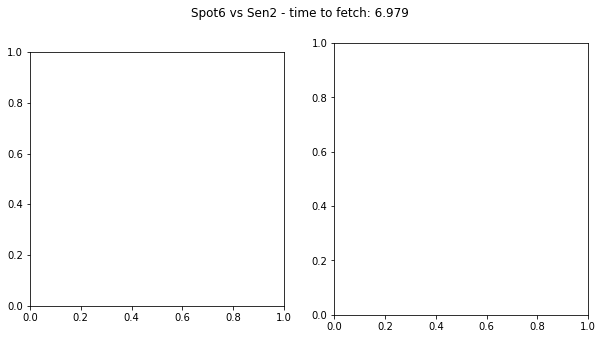

In [81]:
for i in range(0,10):
    start=time.time()
    #a,b = dataset.__getitem__(random.randint(0,len(dataset)))
    _ = next(iter(loader))
    a,b = _[0],_[1]
    end=time.time()
    
    plot_images(a,b,round(end-start,3))